### Состав команды:

- Поляков Александр (Aleksandr Polyakov)
- Востриков Алексей (Alexey Vostrikoff)
- Садыков Динар (Dinar_Sadykow)
- Федотов Андрей (Andrei Fedotov)
- Каштанкина Ксения
- Овчинников Алексей (Aleksey)
- Пьянков Алексей
- Лукошко Роберт (Robert)
- Поперечный Богдан (Bogdan2105)

# Шаг 1. Подготовка данных



In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_graphviz
import subprocess
from scipy.stats import randint as randint
from scipy.stats import uniform
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold

In [2]:
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

sample_submission = pd.read_csv('sample_submission.csv',',')
train = pd.read_csv('train.csv',',')
test  = pd.read_csv('test.csv',',')

In [3]:
def len_of_age(age):
    return len(age_pd_count[age_pd_count['age'] == age])
age_pd_sum = train.groupby(['age']).sum().reset_index().sort_values(by = 'age')[['age','target']]


age_pd_count = pd.DataFrame(train['age'])
age_pd_count['counter'] = age_pd_count['age'].apply(len_of_age)
age_pd_count = age_pd_count.sort_values(by = 'age')

age_pd_count = age_pd_count.drop_duplicates('age')

age_db = age_pd_sum.merge(age_pd_count, how = 'left', on = 'age')
age_db['conversion_age'] = 100*age_db['target']/age_db['counter']

age_db.sort_values('conversion_age', ascending=False).head()
age_conv = age_db.sort_values('conversion_age', ascending=False).drop(['target','counter'], axis = 'columns')




In [4]:
mean_conv = train['target'].sum()/train['target'].count()
mean_conv

0.11277921657494334

In [5]:
age_conv[age_conv['age'] == 97]

,age,conversion_age


In [5]:
object_list = []
for i in train.columns: # перебираем все столбцы
    if (str(train[i].dtype) == 'object') and (i != '_id'): # если тип столбца - object
        print('='*10)
        print(i) # выводим название столбца
        print(set(train[i])) # выводим все его значения (но делаем set - чтоб значения не повторялись)
        print('\n') # выводим пустую строку
        object_list.append(i)

job
{'housemaid', 'technician', 'admin.', 'unemployed', 'management', 'retired', 'student', 'blue-collar', 'entrepreneur', 'self-employed', 'services', 'unknown'}


marital
{'unknown', 'married', 'single', 'divorced'}


education
{'high.school', 'basic.4y', 'illiterate', 'basic.9y', 'basic.6y', 'professional.course', 'university.degree', 'unknown'}


default
{'yes', 'no', 'unknown'}


housing
{'yes', 'no', 'unknown'}


loan
{'yes', 'no', 'unknown'}


contact
{'cellular', 'telephone'}


month
{'mar', 'aug', 'jul', 'sep', 'oct', 'dec', 'apr', 'jun', 'may', 'nov'}


day_of_week
{'wed', 'fri', 'mon', 'tue', 'thu'}


poutcome
{'failure', 'nonexistent', 'success'}




In [52]:
def age_format(age):
    try:
        a = float(age_conv[age_conv['age'] == age]['conversion_age'])
    except:
        a = 0
    if a == 0:
        try:
            omega = float(age_conv[age_conv['age'] == age+1]['conversion_age'])
        except:
            omega = mean_conv
        try:
            alpha = float(age_conv[age_conv['age'] == age-1]['conversion_age'])
        except:
            alpha = mean_conv        
        return max (alpha,omega)
    else:
        return a
    
def pdays_format (pdays):
    if pdays == 999:
        return 0
    else:
        return pdays

# pdays_to_NaN (pdays):
 #   if pdays == 999:
  #      return 0
   # else:
    #    return pdays
    
def unknown_to_NaN (data):
    if data == 'unknown':
        return float('NaN')
    else:
        return data

def preproc(df_input):
    object_list = []
    df_output = df_input.copy()
    list_of_drop = ['_id','month','day_of_week']
    df_output = df_output.drop(list_of_drop, axis = 'columns')
    df.loc[df.pdays == 999, 'is_contact'] = 0
    df.loc[df.pdays >= 0, 'is_contact'] = 1
    df_output['age'] = df_output['age'].apply(age_format)
    for i in df_output.columns: # перебираем все столбцы
         if (str(df_output[i].dtype) == 'object') and (i != '_id'): # если тип столбца - object
                object_list.append(i)

    df_output = pd.get_dummies(df_output, columns = object_list)
    return df_output

In [54]:
train['pdays'].value_counts()

999    23830
3        264
6        257
4         66
12        34
10        31
7         30
2         29
9         29
5         24
13        19
1         17
15        17
8         13
14        12
11        12
17         7
16         6
0          6
22         2
18         2
21         1
20         1
19         1
25         1
27         1
Name: pdays, dtype: int64

In [9]:
age_format(92)

75.0

In [10]:
train_preproc = train.pipe(preproc)
test_preproc = test.pipe(preproc)

In [11]:
df_y_train = list(train_preproc['target'])
df_x_train = train_preproc.drop(['target'], axis = 1)
print('X train ', df_x_train.shape)
print('Y train ', len(df_y_train))

X train  (24712, 48)
Y train  24712


In [43]:
df_x_test  = test_preproc.drop(['target'], axis = 1)

In [12]:
X_train, X_test, y_train, y = train_test_split(df_x_train, df_y_train, test_size=0.2, random_state=42)
print('X_train ', X_train.shape)
print('X_test ',X_test.shape)

X_train  (19769, 48)
X_test  (4943, 48)


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

model0 = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

model0.fit(X_train, y_train)

predict = model0.predict(X_test)                      # делаем предсказание
# dict_model ['KNeighborsClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> KNeighborsClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> KNeighborsClassifier <<< ########## 
              precision    recall  f1-score   support

          0       0.92      0.97      0.94      4387
          1       0.58      0.31      0.40       556

avg / total       0.88      0.90      0.88      4943
 



In [16]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cross_validation import train_test_split

dict_model = {}

model1 = KNeighborsClassifier(n_neighbors=3, weights='uniform', p=2, metric='euclidean')
model1.fit(X_train, y_train)

predict = model1.predict(X_test)                      # делаем предсказание
dict_model ['KNeighborsClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> KNeighborsClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> KNeighborsClassifier <<< ########## 
              precision    recall  f1-score   support

          0       0.93      0.95      0.94      4387
          1       0.53      0.48      0.50       556

avg / total       0.89      0.89      0.89      4943
 



Text(0,0.5,'ROC AUC')

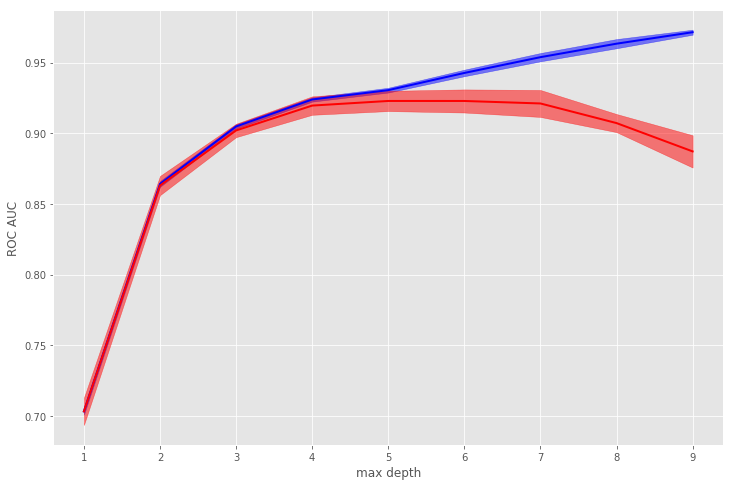

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from ipywidgets import interact, IntSlider
import subprocess

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold

# ---------------------------------------------------------------------
# ищем максимальную точность на графике max_depth

model2 = DecisionTreeClassifier(random_state=123)
model2.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132)
train_scores, valid_scores = validation_curve(model2, X_train, y_train, 
                                              'max_depth', range(1, 10),
                                              cv=cv, scoring='roc_auc')
train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,10), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,10), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1,10), train_score_mean, c='b', lw=2) #синяя линия обучающая выборка
plt.plot(range(1,10), valid_scores_mean, c='r', lw=2) #красная линяя - валидационная выборка

plt.xlabel('max depth')
plt.ylabel('ROC AUC')

# это значит, что мы будем проверять влияние параметра max_depth
# в дапозоне от 1 до 10
# и для этого мы будем использовать 5-fold кросс-валидацию
# с мерой качества mean_absolute_error.
# neg_ потому что по умолчанию в sklearn чем значение меры выше - тем лучше, 
# но в нашем случае нам нужно как раз допускать меньшую ошибку
# ---------------------------------------------------------------------

In [24]:
depth=5 #видно из графика

model2 = DecisionTreeClassifier(max_depth = depth, random_state=123)
model2.fit(X_train, y_train)

predict = model2.predict(X_test)                      # делаем предсказание
dict_model ['DecisionTreeClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> DecisionTreeClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> DecisionTreeClassifier <<< ########## 
              precision    recall  f1-score   support

          0       0.94      0.96      0.95      4387
          1       0.64      0.51      0.57       556

avg / total       0.91      0.91      0.91      4943
 



In [25]:
model3_1 = LogisticRegression()                     # инициализируем модель
model3_1.fit(X_train, y_train)                      # обучаем модель
predict = model3_1.predict(X_test)                      # делаем предсказание
dict_model ['LogisticRegression']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> LogisticRegression <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> LogisticRegression <<< ########## 
              precision    recall  f1-score   support

          0       0.92      0.97      0.95      4387
          1       0.63      0.35      0.45       556

avg / total       0.89      0.90      0.89      4943
 



In [26]:
model3_2 = LogisticRegression(class_weight='balanced')                     # инициализируем модель
model3_2.fit(X_train, y_train)                      # обучаем модель
predict = model3_2.predict(X_test)                      # делаем предсказание
dict_model ['LogisticRegression']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> LogisticRegression <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> LogisticRegression <<< ########## 
              precision    recall  f1-score   support

          0       0.98      0.85      0.91      4387
          1       0.43      0.88      0.57       556

avg / total       0.92      0.85      0.87      4943
 



In [27]:
model3_2_proba = model3_2.predict_proba(X_test )
roc_auc_score(y, model3_2_proba[:, 1])

0.9285536239346794

In [28]:
model3_1_proba = model3_1.predict_proba(X_test )
roc_auc_score(y, model3_1_proba[:, 1])

0.9250274273400974

(-0.01, 1.01)

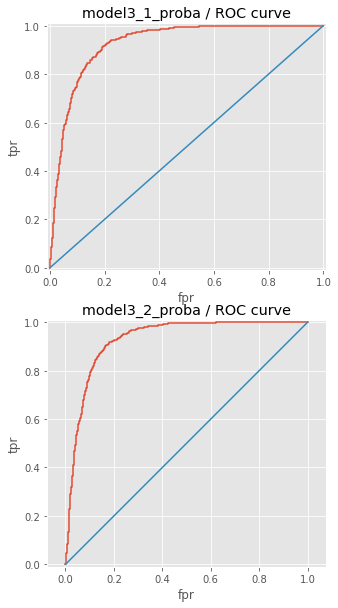

In [31]:
plt.figure(figsize=(5, 10))

#subplot 1
plt.subplot(211)
predict_proba1 = model3_1.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba1[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('model3_1_proba / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#subplot 2
plt.subplot(212)
predict_proba2 = model3_2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba2[:,1])
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.axis('equal')
plt.grid(True)
plt.title('model3_2_proba / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

In [32]:
from scipy.stats import randint as randint
from scipy.stats import uniform

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold

# Определим пространство поиска

param_grid = {
    'criterion': ['gini', 'entropy'], #критерии
    'max_depth': randint(2, 8), #максимальная глубина от 2 до 8
    'min_samples_leaf': randint(5, 10), #минимальное количество объектов в вершие дерева, достаточное чтоб дробить дерево на части
    'class_weight': [None, 'balanced']} #объекты классов, которые недопредставлены в выборке, будет взвешивать и балансировать

# Некоторые параметры мы задали не простым перечислением значений, а с помощью распределений.

# Будем делать 200 запусков поиска
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model4 = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(model4, param_distributions=param_grid, n_iter=200, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=123) #200 переборов, n_jobs=-1 дает параллельное вычисление
# А дальше, просто .fit()
random_search.fit(X_train, y_train)
model4best = random_search.best_estimator_

predict = model4best.predict(X_test)                      # делаем предсказание
dict_model ['DecisionTreeClassifier random_search']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> DecisionTreeClassifier random_search <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> DecisionTreeClassifier random_search <<< ########## 
              precision    recall  f1-score   support

          0       0.99      0.84      0.91      4387
          1       0.42      0.91      0.57       556

avg / total       0.92      0.85      0.87      4943
 



In [33]:
model4_proba = random_search.predict_proba(X_test )
roc_auc_score(y, model4_proba[:, 1])

0.9311936591597476

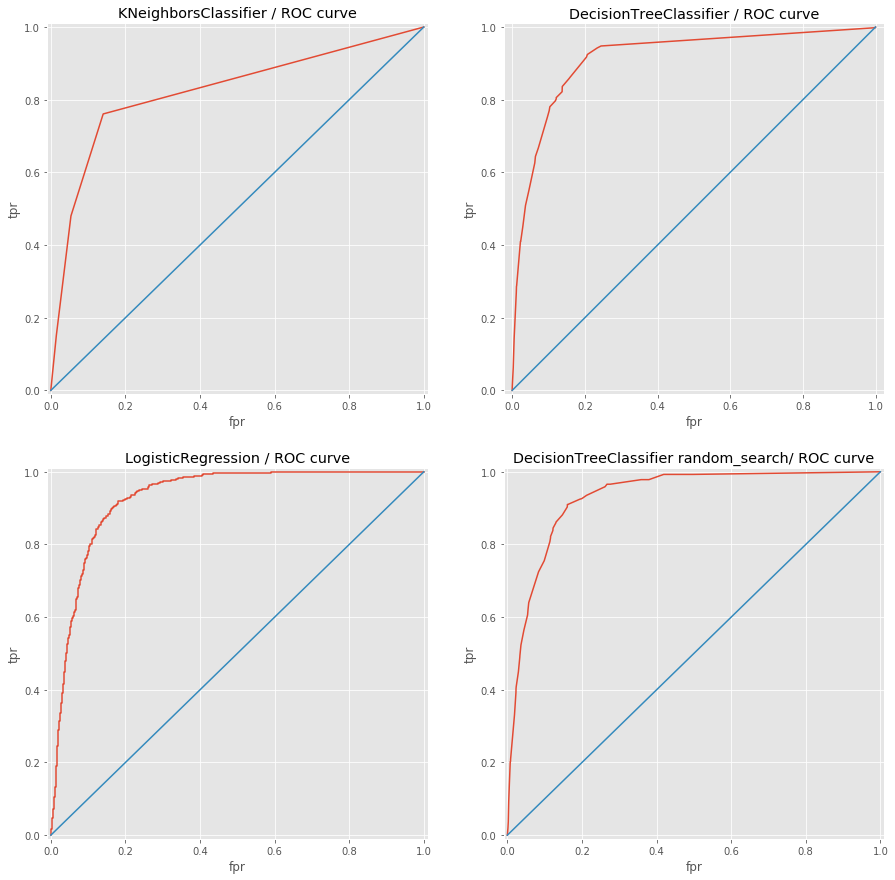

In [34]:
# Потроить roc-кривые всех можелей на одном графике
# Вывести roc_auc каждой моделе
# Подпишите оси и линии

plt.figure(figsize=(15, 15))

#subplot 1
plt.subplot(221)
predict_proba1 = model1.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba1[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('KNeighborsClassifier / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#subplot 2
plt.subplot(222)
predict_proba2 = model2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba2[:,1])
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.axis('equal')
plt.grid(True)
plt.title('DecisionTreeClassifier / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#subplot 3
plt.subplot(223)
predict_proba3_2 = model3_2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba3_2[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('LogisticRegression / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#subplot 4
plt.subplot(224)
predict_proba3 = model4best.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba3[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('DecisionTreeClassifier random_search/ ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.show()

In [35]:
from sklearn.cross_validation import cross_val_score
# Сделать k-fold (10 фолдов) кросс-валидацию каждой модели
# И посчитать средний roc_auc

cross1 = cross_val_score(model1,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross2 = cross_val_score(model2,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross3 = cross_val_score(model3_2,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross4 = cross_val_score(model4best,df_x_train,df_y_train,scoring='roc_auc', cv=10)

print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
      '\nModel 1. KNeighborsClassifier\t\t\t{:.4f}                   \
      \nModel 2. DecisionTreeClassifier\t\t\t{:.4f}                  \
      \nModel 3. LogisticRegression\t\t\t{:.4f}                      \
      \nModel 4. DecisionTreeClassifier random_search\t{:.4f} '
      .format( (sum(cross1) / float(len(cross1))),
              (sum(cross2) / float(len(cross2))),
              (sum(cross3) / float(len(cross3))),
              (sum(cross4) / float(len(cross4))),
             ) )

/Users/aleksandrpolakov/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


########## >>> AVG roc_auc for Train: <<< ########## 
Model 1. KNeighborsClassifier			0.8339                         
Model 2. DecisionTreeClassifier			0.9228                        
Model 3. LogisticRegression			0.9298                            
Model 4. DecisionTreeClassifier random_search	0.9379 


In [47]:
predict = model4best.predict(df_x_test)
df_test['target'] = predict
test['target'] = df_test['target'].astype('int')
print(list(test.columns))

['_id', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'target']


In [50]:
df_result = test.drop(['age', 'job', 'marital', 'education', 'default', 'housing',
                          'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign',
                          'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
                          'cons.conf.idx', 'euribor3m', 'nr.employed'], axis = 1)

In [51]:
df_result.to_csv('result_submission.csv', sep=',', encoding='utf-8',index=False)